## Dataset
https://www.kaggle.com/c/dogs-vs-cats/data

In [66]:
%matplotlib inline
# Packages
import os
import sys
import numpy as np
from PIL import Image
from scipy import ndimage
import matplotlib as plt

In [230]:
def batch_preprocessing():
    width = 500
    height = 500
    train_dir = 'datasets/train/'
    test_dir = 'datasets/test/'

    # Pre-process training set
    for image in os.listdir(train_dir):
        print('Resizing image ' + image)
        img = Image.open(os.path.join(train_dir,image))
        img = img.resize((width,height), Image.BILINEAR)
        img.save(os.path.join(train_dir,image))
    print('Batch pre-processing on {} files in training set complete'.format(len(os.listdir(train_dir))))
    print('///////////////')
    # Pre-process test set
    for image in os.listdir(test_dir):
        print('Resizing image ' + image)
        img = Image.open(os.path.join(test_dir,image))
        img = img.resize((width,height), Image.BILINEAR)
        img.save(os.path.join(test_dir,image))
    print('Batch pre-processing on {} files in test set complete'.format(len(os.listdir(test_dir))))

In [231]:
def load_data():
    
    train_dir = 'datasets/train/'
    test_dir = 'datasets/test/'
    # initialize arrays
    files_train = len(os.listdir(train_dir))
    files_test = len(os.listdir(test_dir))
    train_set_x = np.random.randint(0,255,size=(files_train,500,500,3),dtype='uint8')
    train_set_y = np.zeros((1,files_train))
    test_set_x = np.random.randint(0,255,size=(files_test,500,500,3),dtype='uint8')
    test_set_y = np.zeros((1,files_test))

    # load training files
    for i,image in zip(range(files_train),os.listdir(train_dir)):   
        train_set_x[i] = np.array(Image.open(os.path.join(train_dir,image)))
        # create labels (0: cat, 1: dog)
        if 'dog' in str(os.path.join(train_dir,image)):
            train_set_y[:,i] = 1
    # load test files 
    for i,image in zip(range(files_test),os.listdir(test_dir)):   
        test_set_x[i] = np.array(Image.open(os.path.join(test_dir,image)))
        # create labels (0: cat, 1: dog)
        if 'dog' in str(os.path.join(test_dir,image)):
            test_set_y[:,i] = 1
            
    assert(train_set_x.shape == (files_train,500,500,3))
    assert(train_set_x.shape == (files_train,500,500,3))
    
    return train_set_x,train_set_y,test_set_x,test_set_y

In [232]:
batch_preprocessing()
#os.remove('.DS_Store')

Resizing image cat.10.jpg
Resizing image cat.20.jpg
Resizing image cat.21.jpg
Resizing image cat.22.jpg
Resizing image cat.23.jpg
Resizing image cat.8.jpg
Resizing image cat.9.jpg
Resizing image dog.12494.jpg
Resizing image dog.12495.jpg
Resizing image dog.12496.jpg
Batch pre-processing on 10 files in training set complete
///////////////
Resizing image cat.0.jpg
Resizing image cat.1.jpg
Resizing image dog.10680.jpg
Resizing image dog.10681.jpg
Resizing image dog.10682.jpg
Batch pre-processing on 5 files in test set complete


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]])

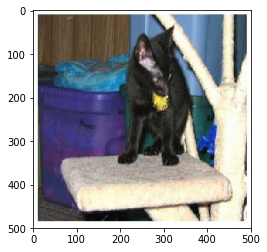

In [233]:
train_set_x,train_set_y,test_set_x,test_set_y = load_data()
train_set_x.shape
plt.pyplot.imshow(train_set_x[4])
train_set_y

In [237]:
m_train = train_set_x.shape[0]
m_test = test_set_x.shape[0]
num_px = train_set_x.shape[1]
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0],-1).T
test_set_x_flatten = np.reshape(test_set_x,(num_px*num_px*3,m_test))
print(train_set_x_flatten.shape)
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

(750000, 10)


In [238]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [239]:
def propagate(w,b,X,Y):
    m = X.shape[1]
    # forward prop
    A = sigmoid(np.dot(np.transpose(w),X)+b)
    cost = (-1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    # back prop
    dw = (1/m)*np.dot(X,np.transpose(A-Y))
    db = (1/m)*np.sum(A-Y)

    cost = np.squeeze(cost)

    grads = {"dw": dw,
            "db": db}
    
    return grads,cost

In [244]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        if i % 25 == 0:
            costs.append(cost)
        
        if print_cost and i % 25 == 0:
            print("Cost after iteration i: {}".format(i,cost))
        
    params = {"w": w,
              "b": b}
        
    grads = {"dw": dw,
             "db": db}
        
    return params, grads, costs

In [245]:
def predict(w,b,X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        Y_prediction[np.where(A>0.5)] = 1
    
    return Y_prediction
    
    

In [246]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost=False):
    
    w = np.zeros((X_train.shape[0],1))
    b = np.zeros(1)
    parameters, grads, costs = optimize(w,b,X_train,Y_train, num_iterations, learning_rate)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    
    print("Training set accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_train-Y_train) * 100)))
    print("Test set accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    model_out = {"costs": costs,
                     "Y_prediction_test": Y_prediction_test,
                     "Y_prediction_train": Y_prediction_train,
                     "w": w,
                     "b": b,
                     "learning_rate": learning_rate,
                     "num_iterations": num_iterations}
    return model_out

In [247]:
model_out = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Training set accuracy: 70.0%
Test set accuracy: 40.0%


In [250]:
model_out["Y_prediction_train"]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## How does varying learning rate, doing feature engineering, and adding regularization affect cost?


In [251]:
? np.random.permutation

References:

http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c